In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
zo_opt_file = "ZO_opt.csv"
hybrid_file = "Hybrid.csv"
peft_file = "PEFT.csv"
mem_file = "Mem_usage.csv"

In [3]:
zo_opt_df = pd.read_csv(zo_opt_file).dropna(how='all')
hybrid_df = pd.read_csv(hybrid_file).dropna(how='all')
peft_df = pd.read_csv(peft_file).dropna(how='all')
mem_df = pd.read_csv(mem_file).dropna(how='all')

In [12]:
peft_df

,Method,Model,BoolQ,CB,COPA,DROP,MNLI,MultiRC,ReCoRD,RTE,SQuAD,SNLI,SST-2,SST-5,TREC,WIC,WSC
0,ZERO-SHOT,OPT-13B,59.1,46.4,80.0,14.4,NaN,46.7,81.0,59.4,46.6,NaN,58.5,NaN,NaN,55.2,38.3
1,FT,OPT-13B,76.4,84.0,79.0,31.5,NaN,71.1,74.1,70.7,84.7,NaN,91.5,NaN,NaN,70.0,63.5
2,MeZO,OPT-13B,67.6,67.9,88.0,30.9,NaN,60.1,81.7,66.1,84.7,NaN,91.4,NaN,NaN,61.1,63.5
3,MeZO (LoRA),OPT-13B,73.8,66.1,84.0,31.4,NaN,61.5,81.2,67.9,83.8,NaN,89.6,NaN,NaN,59.7,64.4
4,MeZO (prefix),OPT-13B,73.1,69.6,87.0,28.9,NaN,63.7,81.4,70.8,84.2,NaN,90.7,NaN,NaN,59.9,60.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,LoRA (rank=8),RoBERTa-Base,NaN,NaN,NaN,NaN,86.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,GaLore (rank=8),RoBERTa-Base,NaN,NaN,NaN,NaN,87.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,LORENZA (rank=8),RoBERTa-Base,NaN,NaN,NaN,NaN,87.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,LoHO-SGD-inter,RoBERTa-large,NaN,NaN,NaN,NaN,80.60,NaN,NaN,NaN,NaN,NaN,NaN,85.8,NaN,NaN,NaN


In [4]:
SMALL_MODELS = ("RoBERTa-Base", "RoBERTa-large", "RoBERTa-large ")
MEDIUM_MODELS = ("OPT-1.3B", "OPT-2.7B")
LARGE_MODELS = ("LLaMA-7b", "LLaMA2-7b", "LlaMA3-8b", "OPT-13B")

In [5]:
TASK_TYPE_TO_DATASET = {"Natural Language Inference": ("SNLI", "MNLI", "RTE", "CB"),
                        "Sentiment Analysis": ("SST-2", "SST-5"),
                        "Reading Comprehension/Question Answering": ("SQuAD", "MultiRC", "ReCoRD", "DROP", "BoolQ"),
                        "Commonsense & Causal Reasoning": ("COPA", "WSC"),
                        "Word Sense/Contextual Meaning": ("WIC"),
                        "Question Classification": ("TREC")}

/tmp/ipykernel_408/717187794.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')
/tmp/ipykernel_408/717187794.py:27: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate()
/tmp/ipykernel_408/717187794.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')
/tmp/ipykernel_408/717187794.py:27: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate()
/tmp/ipykernel_408/717187794.py:26: FutureWarning: DataFrame.fillna with 'method' is

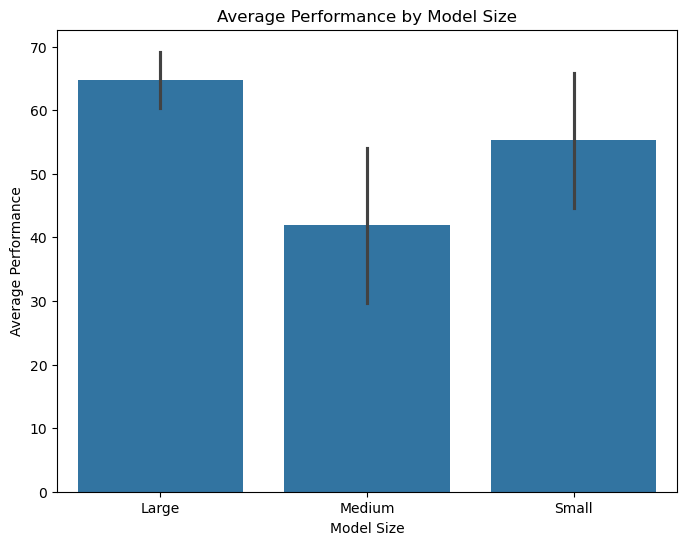

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# File paths for performance CSVs
zo_opt_file = "ZO_opt.csv"
hybrid_file = "Hybrid.csv"
peft_file = "PEFT.csv"

# Read CSV files and drop rows where all values are NaN
zo_opt_df = pd.read_csv(zo_opt_file).dropna(how='all')
hybrid_df = pd.read_csv(hybrid_file).dropna(how='all')
peft_df = pd.read_csv(peft_file).dropna(how='all')

# Define model size categories
SMALL_MODELS = ("RoBERTa-Base", "RoBERTa-large", "RoBERTa-large ")
MEDIUM_MODELS = ("OPT-1.3B", "OPT-2.7B")
LARGE_MODELS = ("LLaMA-7b", "LLaMA2-7b", "LlaMA3-8b", "OPT-13B")

def clean_dataframe(df):
    """
    Interpolates missing values in a DataFrame.
    First fills leading/trailing NaNs, then interpolates numeric columns.
    """
    df = df.fillna(method='ffill').fillna(method='bfill')
    df = df.interpolate()
    return df

def get_model_size(model_name):
    """
    Returns the model size category for a given model name.
    """
    model_name = model_name.strip()  # remove extra whitespace
    if model_name in SMALL_MODELS:
        return 'Small'
    elif model_name in MEDIUM_MODELS:
        return 'Medium'
    elif model_name in LARGE_MODELS:
        return 'Large'
    else:
        return 'Unknown'

def aggregate_performance(perf_dfs):
    """
    Aggregates performance data from multiple DataFrames.
    
    Args:
        perf_dfs (list): List of DataFrames containing performance metrics.
        
    Returns:
        aggregated (DataFrame): A DataFrame with each model's average performance and its size.
    """
    # Clean all performance dataframes
    perf_dfs = [clean_dataframe(df) for df in perf_dfs]
    
    # Merge performance data on 'Model' column
    merged_perf = perf_dfs[0]
    for df in perf_dfs[1:]:
        merged_perf = pd.merge(merged_perf, df, on='Model', how='outer', suffixes=('', '_dup'))
    
    # Average across all numeric columns (excluding the 'Model' column)
    numeric_cols = merged_perf.select_dtypes(include=[np.number]).columns
    merged_perf['Avg_Performance'] = merged_perf[numeric_cols].mean(axis=1)
    
    # Add model size classification
    merged_perf['Model_Size'] = merged_perf['Model'].apply(get_model_size)
    
    return merged_perf[['Model', 'Avg_Performance', 'Model_Size']]

def visualize_performance(aggregated):
    """
    Visualizes average performance by model size.
    
    Args:
        aggregated (DataFrame): DataFrame with columns ['Model', 'Avg_Performance', 'Model_Size'].
    """
    # Plot average performance by model size using a bar plot
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Model_Size', y='Avg_Performance', data=aggregated, ci='sd')
    plt.title("Average Performance by Model Size")
    plt.xlabel("Model Size")
    plt.ylabel("Average Performance")
    plt.show()

# List of performance DataFrames
performance_dfs = [zo_opt_df, hybrid_df, peft_df]

# Aggregate performance results
aggregated_results = aggregate_performance(performance_dfs)

# Visualize the performance by model size
visualize_performance(aggregated_results)

In [8]:
aggregated_results

,Model,Avg_Performance,Model_Size
0,LLaMA-7b,68.612500,Large
1,LLaMA-7b,58.834746,Large
2,LLaMA-7b,58.293079,Large
3,LLaMA-7b,58.226413,Large
4,LLaMA-7b,58.734746,Large
...,...,...,...
326,RoBERTa-large,61.426412,Small
327,RoBERTa-large,61.443079,Small
328,RoBERTa-large,61.422246,Small
329,RoBERTa-large,61.484746,Small
